## Comparison tutorial

In this notebook, we are going to explore different method to anonymize a multi table dataset. An initial analysis enabled us to draw some initial conclusions and to question the ability of IICT to preserve the utility and privacy of a dataset.
The first method implemented was the minimization of the distance between patient and visit but we found some edge cases.
First, when the variables of the parent table do not discriminate the count of the child table, the implemented method will not preserve the properties of the original dataset. 
Secondly, we observed that the first implemented method, tended to lose information, the number of unique patients after IICT was often lower than the number of unique patients in the original dataset.

We started looking for other method to assign a patient to a visit. 

In this notebook we will compare :
- The **REGULAR** method, which minimizes the distance between patient and visit. The patient closest to the visit is assigned to the visit.
- The **LSA** method consists in duplicating patients as many times as their original number of visits, then performing an LSA to assign a patient to a visit.
- The **LSA Noised** method consists in duplicating patients as many times as their avatarized number of visits, then performing an LSA to assign a patient to a visit. If the avatarized number of visits is higher/lower than the original number of visits, we add/delete patients to have the same number of visits as the original.
- The **LSA Noised diff Length** method consists in duplicating patients as many times as their avatarized number of visits, then performing an LSA to assign a patient to a visit. If the avatarized number of visits is higher or lower than the initial number of visits, we return a lower or equal number of visits.
- The **LSA Boost** method consists in duplicating more patient than the original number of visits, then performing an LSA to assign a patient to a visit.


In [1]:
import numpy as np
import pandas as pd
import os
import saiph
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

url = os.environ.get("AVATAR_BASE_URL")
username = os.environ.get("AVATAR_USERNAME")
password = os.environ.get("AVATAR_PASSWORD")

from avatars.client import ApiClient
from avatars.models import AvatarizationJobCreate, AvatarizationParameters, PrivacyMetricsMultiTableJobCreate, AvatarizationMultiTableJobCreate
from avatars.models import ReportCreate
from avatars.models import TableReference, TableLink, PrivacyMetricsParameters,BasePrivacyMetricsParameters ,PrivacyMetricsMultiTableParameters, AvatarizationMultiTableParameters
from avatars.models import Projections
from scipy.optimize import linear_sum_assignment
client = ApiClient(base_url=url)
client.authenticate(username=username, password=password)

map_color={'Regular':"lightgrey",'LSA':'teal','LSA Noised':'lightblue','LSA Noised diff length':'lightgreen','LSA boost':'gold' ,'originals':'black'}

# Anonymization of a multitable dataset

## Import and manipulate data

In [2]:
patient = pd.read_csv('patient.csv').drop(columns=['Unnamed: 0'])
doctor = pd.read_csv('doctor.csv').drop(columns=['Unnamed: 0']).rename(columns={"age":"age_doctor"})
visit =  pd.read_csv('visit.csv').drop(columns=['Unnamed: 0'])

patient_to_avat = patient.drop(columns=['patient_id'])
doctor_to_avat = doctor.drop(columns=['doctor_id'])

patient_to_avat_with_visit_nb = patient.copy()
patient_to_avat_with_visit_nb['nb_visit'] = visit['patient_id'].value_counts().sort_index()
patient_to_avat_with_visit_nb['nb_visit'].fillna(0, inplace=True)
patient_to_avat_with_visit_nb['nb_visit'] = patient_to_avat_with_visit_nb['nb_visit'].astype('int')

doctor_to_avat_with_visit_nb = doctor.copy()
doctor_to_avat_with_visit_nb['nb_visit'] = visit['doctor_id'].value_counts().sort_index()
doctor_to_avat_with_visit_nb['nb_visit'].fillna(0, inplace=True)
doctor_to_avat_with_visit_nb['nb_visit'] = doctor_to_avat_with_visit_nb['nb_visit'].astype('int')

visit_after_bib = visit.join(
        patient.set_index("patient_id"), on="patient_id"
    )
visit_after_bib = visit_after_bib.join(
        doctor.set_index("doctor_id"), on="doctor_id"
    )
visit_after_bib_to_avat = visit_after_bib.drop(columns=['visit_id', 'patient_id', 'doctor_id'])

## Launch anonymization job

In [3]:
dataset_patient = client.pandas_integration.upload_dataframe(patient,
                                                             name="patient",
                                                             identifier_variables="patient_id")

dataset_patient_with_visit = client.pandas_integration.upload_dataframe(patient_to_avat_with_visit_nb,
                                                                        name="patient_with_visit",
                                                                        identifier_variables=["patient_id"])

dataset_doctor = client.pandas_integration.upload_dataframe(doctor,
                                                            name="doctor",
                                                            identifier_variables=["doctor_id"])

dataset_doctor_with_visit = client.pandas_integration.upload_dataframe(doctor_to_avat_with_visit_nb,
                                                                        name="doctor_with_visit",
                                                                        identifier_variables=["doctor_id"])

dataset_visit = client.pandas_integration.upload_dataframe(visit,
                                                          name="visit",
                                                          identifier_variables=["visit_id", "patient_id", "doctor_id"])

dataset_visit_enriched = client.pandas_integration.upload_dataframe(visit_after_bib,
                                                                    name="visit_enriched",
                                                                    identifier_variables=["visit_id", "patient_id", "doctor_id"])

# PATIENT
job_patient = client.jobs.create_avatarization_job(
    AvatarizationJobCreate(
        parameters=AvatarizationParameters(k=20, dataset_id=dataset_patient.id),
    )
)
job_patient = client.jobs.get_avatarization_job(id=job_patient.id, timeout=100)
avatar_patient = client.pandas_integration.download_dataframe(job_patient.result.sensitive_unshuffled_avatars_datasets.id)

job_patient_with_visit = client.jobs.create_avatarization_job(
    AvatarizationJobCreate(
        parameters=AvatarizationParameters(k=20, dataset_id=dataset_patient_with_visit.id),
    )
)
job_patient_with_visit = client.jobs.get_avatarization_job(id=job_patient_with_visit.id, timeout=100)
avatar_patient_with_visit = client.pandas_integration.download_dataframe(job_patient_with_visit.result.sensitive_unshuffled_avatars_datasets.id)



# DOCTOR
job_doctor = client.jobs.create_avatarization_job(
    AvatarizationJobCreate(
        parameters=AvatarizationParameters(k=10, dataset_id=dataset_doctor.id),
    )
)
job_doctor = client.jobs.get_avatarization_job(id=job_doctor.id, timeout=100)
avatar_doctor = client.pandas_integration.download_dataframe(job_doctor.result.sensitive_unshuffled_avatars_datasets.id)

job_doctor_with_visit = client.jobs.create_avatarization_job(
    AvatarizationJobCreate(
        parameters=AvatarizationParameters(k=10, dataset_id=dataset_doctor_with_visit.id),
    )
)
job_doctor_with_visit = client.jobs.get_avatarization_job(id=job_doctor_with_visit.id, timeout=100)
avatar_doctor_with_visit = client.pandas_integration.download_dataframe(job_doctor_with_visit.result.sensitive_unshuffled_avatars_datasets.id)

#VISIT
job_visit = client.jobs.create_avatarization_job(
    AvatarizationJobCreate(
        parameters=AvatarizationParameters(k=10, dataset_id=dataset_visit_enriched.id),
    )
)
job_visit = client.jobs.get_avatarization_job(id=job_visit.id, timeout=100)
avatar_visit = client.pandas_integration.download_dataframe(job_visit.result.sensitive_unshuffled_avatars_datasets.id)





## Initialize models and calculate coordinates

In [4]:
# PATIENT

model_patient = saiph.fit(patient_to_avat)
coord_patient_ori = saiph.transform(patient_to_avat, model_patient)
coord_patient_avat = saiph.transform(avatar_patient, model_patient)
coord_patient_avat_visit = saiph.transform(avatar_patient_with_visit.drop(columns=['nb_visit']), model_patient)

avatar_patient['patient_id'] = list(range(len(avatar_patient)))
avatar_patient_with_visit['patient_id'] = list(range(len(avatar_patient_with_visit)))


# DOCTOR

model_doctor = saiph.fit(doctor_to_avat)
coord_doctor_ori = saiph.transform(doctor_to_avat, model_doctor)
coord_doctor_avat = saiph.transform(avatar_doctor, model_doctor)
coord_doctor_avat_visit = saiph.transform(avatar_doctor_with_visit.drop(columns=['nb_visit']), model_doctor)

avatar_doctor['doctor_id'] = list(range(len(avatar_doctor)))
avatar_doctor_with_visit['doctor_id'] = list(range(len(avatar_doctor_with_visit)))

# VISIT

model_visit = saiph.fit(visit_after_bib_to_avat)
coord_visit_enriched_ori = saiph.transform(visit_after_bib_to_avat, model_visit)
coord_visit_enriched_avat = saiph.transform(avatar_visit, model_visit)

#coordinates of patient-related variables in the avatarized visit table
coord_patient_in_visit_avatars = saiph.transform(avatar_visit[patient_to_avat.columns], model_patient)
#coordinates of the doctor-related variables in the avatarized visit table
coord_doctor_in_visit_avatars = saiph.transform(avatar_visit[doctor_to_avat.columns], model_doctor)

avatar_visit['visit_id'] = list(range(len(avatar_visit)))

## IICT

In [5]:
avatar_patient_visit = avatar_patient_with_visit.drop(columns=['nb_visit'])
avatar_doctor_visit = avatar_doctor_with_visit.drop(columns=['nb_visit'])

### PATIENT

original_visit_per_patient = dict(visit['patient_id'].value_counts())
avatar_visit_per_patient = dict(avatar_patient_with_visit['nb_visit'])

# REGULAR
distances_regular = distance_matrix(coord_patient_in_visit_avatars, coord_patient_avat)
#closest_id_regular = distances_regular.argmin(axis=1)
# if there are multiple closest avatars, we randomly choose one
k_closest_id = [
    np.nonzero(distances_regular[i] == distances_regular[i].min()) for i in range(len(distances_regular))
]
closest_id_regular = [np.random.choice(k_closest_id[i][0]) for i in range(len(distances_regular))]

closest_parent_regular = patient.loc[closest_id_regular, "patient_id"]
avatar_visit['patient_id_regular'] = list(closest_parent_regular)

# LSA
tmp_dfs = []
tmp_dfs_boost = []
# duplicate the patient to match the number of visits per patient
for id, n in original_visit_per_patient.items():
        tmp_df = avatar_patient[avatar_patient["patient_id"] == id].sample(n=n, replace=True, random_state=1)
        tmp_dfs.append(tmp_df)
        # add more patients than the original number of visits
        tmp_df_boost = avatar_patient[avatar_patient["patient_id"] == id].sample(n=n+2, replace=True, random_state=1)
        tmp_dfs_boost.append(tmp_df_boost)

table_patient_with_duplicates = pd.concat(tmp_dfs).reset_index(drop=True)
# project the duplicated patient into the same space as the avatarized patient
coord_patient_duplicated = saiph.transform(table_patient_with_duplicates, model_patient)
# calculation of the distance matrix between patient-related variables in the avatarized visit table and the duplicated patients
distances_lsa = distance_matrix(coord_patient_in_visit_avatars, coord_patient_duplicated)
row_ind, col_ind = linear_sum_assignment(distances_lsa)
# reassign the patient_id to the avatarized visit
closest_parent_lsa = table_patient_with_duplicates['patient_id'].loc[col_ind]
avatar_visit['patient_id_lsa'] = list(closest_parent_lsa)

# LSA BOOST
table_patient_with_duplicates_boost = pd.concat(tmp_dfs_boost).reset_index(drop=True)
coord_patient_duplicated_boost = saiph.transform(table_patient_with_duplicates_boost, model_patient)

distances_lsa_boost = distance_matrix(coord_patient_in_visit_avatars, coord_patient_duplicated_boost)
row_ind, col_ind = linear_sum_assignment(distances_lsa_boost)
closest_parent_lsa_boost = table_patient_with_duplicates_boost['patient_id'].loc[col_ind]
avatar_visit['patient_id_lsa_boost']=np.NaN
avatar_visit.loc[row_ind,'patient_id_lsa_boost']= list(closest_parent_lsa_boost)


# LSA Noised
tmp_dfs = []
# duplicate the patient to match the number of avatarized visits per patient
for id, n in avatar_visit_per_patient.items():
        tmp_df = avatar_patient_visit[avatar_patient_visit["patient_id"] == id].sample(n=n, replace=True, random_state=1)
        tmp_dfs.append(tmp_df)
table_patient_with_duplicates_noised = pd.concat(tmp_dfs).reset_index(drop=True)
table_patient_with_duplicates_noised2=table_patient_with_duplicates_noised.copy()

# if the number of duplicated patients is less than the number of visits, we sample with replacement
if len(table_patient_with_duplicates_noised) > len(visit):
    table_patient_with_duplicates_noised= table_patient_with_duplicates_noised.sample(len(visit), replace=False).reset_index(drop=True)
else:
    table_patient_with_duplicates_noised = table_patient_with_duplicates_noised.sample(len(visit), replace=True).reset_index(drop=True)
coord_patient_duplicated_noised = saiph.transform(table_patient_with_duplicates_noised, model_patient)
distances_lsa_noised = distance_matrix(coord_patient_in_visit_avatars, coord_patient_duplicated_noised)
row_ind, col_ind = linear_sum_assignment(distances_lsa_noised)
closest_parent_lsa_noised = table_patient_with_duplicates_noised['patient_id'].loc[col_ind]
avatar_visit['patient_id_lsa_noised'] = list(closest_parent_lsa_noised)

## LSA NOISED DIFF LENGTH 
coord_patient_duplicated_noised2 = saiph.transform(table_patient_with_duplicates_noised2, model_patient)
distances_lsa_noised_diff_length = distance_matrix(coord_patient_in_visit_avatars, coord_patient_duplicated_noised2)
row_ind, col_ind = linear_sum_assignment(distances_lsa_noised_diff_length)
closest_parent_lsa_noised_diff_length = table_patient_with_duplicates_noised2['patient_id'].loc[col_ind]
avatar_visit['patient_id_lsa_noised_diff_length']=np.NaN
avatar_visit.loc[row_ind,'patient_id_lsa_noised_diff_length']=list(closest_parent_lsa_noised_diff_length)


In [6]:

### DOCTOR
original_visit_per_doctor = dict(visit['doctor_id'].value_counts())
avatar_visit_per_doctor = dict(avatar_doctor_with_visit['nb_visit'])


#regular
distances_regular = distance_matrix(coord_doctor_in_visit_avatars, coord_doctor_avat)
#closest_id_regular = distances_regular.argmin(axis=1)
k_closest_id = [
    np.nonzero(distances_regular[i] == distances_regular[i].min()) for i in range(len(distances_regular))
]
closest_id_regular = [np.random.choice(k_closest_id[i][0]) for i in range(len(distances_regular))]


closest_parent_regular = doctor.loc[closest_id_regular, "doctor_id"]
avatar_visit['doctor_id_regular'] = list(closest_parent_regular)

#lsa 
tmp_dfs = []
tmp_dfs_boost = []
for id, n in original_visit_per_doctor.items():
        tmp_df = avatar_doctor[avatar_doctor["doctor_id"] == id].sample(n=n, replace=True, random_state=1)
        tmp_dfs.append(tmp_df)
        tmp_df_boost = avatar_doctor[avatar_doctor["doctor_id"] == id].sample(n=n+2, replace=True, random_state=1)
        tmp_dfs_boost.append(tmp_df_boost)

table_doctor_with_duplicates = pd.concat(tmp_dfs).reset_index(drop=True)
coord_doctor_duplicated = saiph.transform(table_doctor_with_duplicates, model_doctor)
distances_lsa = distance_matrix(coord_doctor_in_visit_avatars, coord_doctor_duplicated)
row_ind, col_ind = linear_sum_assignment(distances_lsa)
closest_parent_lsa = table_doctor_with_duplicates['doctor_id'].loc[col_ind]
avatar_visit['doctor_id_lsa'] = list(closest_parent_lsa)


#LSA BOOST
table_doctor_with_duplicates_boost = pd.concat(tmp_dfs_boost).reset_index(drop=True)
coord_doctor_duplicated_boost = saiph.transform(table_doctor_with_duplicates_boost, model_doctor)
distances_lsa_boost = distance_matrix(coord_doctor_in_visit_avatars, coord_doctor_duplicated_boost)
row_ind, col_ind = linear_sum_assignment(distances_lsa_boost)
closest_parent_lsa_boost = table_doctor_with_duplicates_boost['doctor_id'].loc[col_ind]
avatar_visit['doctor_id_lsa_boost']=np.NaN
avatar_visit.loc[row_ind,'doctor_id_lsa_boost']= list(closest_parent_lsa_boost)

#lsa noised
tmp_dfs = []
for id, n in avatar_visit_per_doctor.items():
        tmp_df = avatar_doctor_visit[avatar_doctor_visit["doctor_id"] == id].sample(n=n, replace=True, random_state=1)
        tmp_dfs.append(tmp_df)
table_doctor_with_duplicates_noised = pd.concat(tmp_dfs).reset_index(drop=True)
table_doctor_with_duplicates_noised2 = table_doctor_with_duplicates_noised.copy()

if len(table_doctor_with_duplicates_noised) > len(visit):
    table_doctor_with_duplicates_noised= table_doctor_with_duplicates_noised.sample(len(visit), replace=False).reset_index(drop=True)
else:
    table_doctor_with_duplicates_noised= table_doctor_with_duplicates_noised.sample(len(visit), replace=True).reset_index(drop=True)
coord_doctor_duplicated_noised = saiph.transform(table_doctor_with_duplicates_noised, model_doctor)
distances_lsa_noised = distance_matrix(coord_doctor_in_visit_avatars, coord_doctor_duplicated_noised)
row_ind, col_ind = linear_sum_assignment(distances_lsa_noised)
closest_parent_lsa_noised = table_doctor_with_duplicates_noised['doctor_id'].loc[col_ind]
avatar_visit['doctor_id_lsa_noised'] = list(closest_parent_lsa_noised)

## LSA NOISED DIFF LENGTH 

coord_doctor_duplicated_noised2 = saiph.transform(table_doctor_with_duplicates_noised2, model_doctor)
distances_lsa_noised_diff_length = distance_matrix(coord_doctor_in_visit_avatars, coord_doctor_duplicated_noised2)
row_ind, col_ind = linear_sum_assignment(distances_lsa_noised_diff_length)

closest_parent_lsa_noised_diff_length = table_doctor_with_duplicates_noised2['doctor_id'].loc[col_ind]
avatar_visit['doctor_id_lsa_noised_diff_length']=np.NaN
avatar_visit.loc[row_ind,'doctor_id_lsa_noised_diff_length']= list(closest_parent_lsa_noised_diff_length)


## Distribution

In this section we will compare the distribution of every different method 

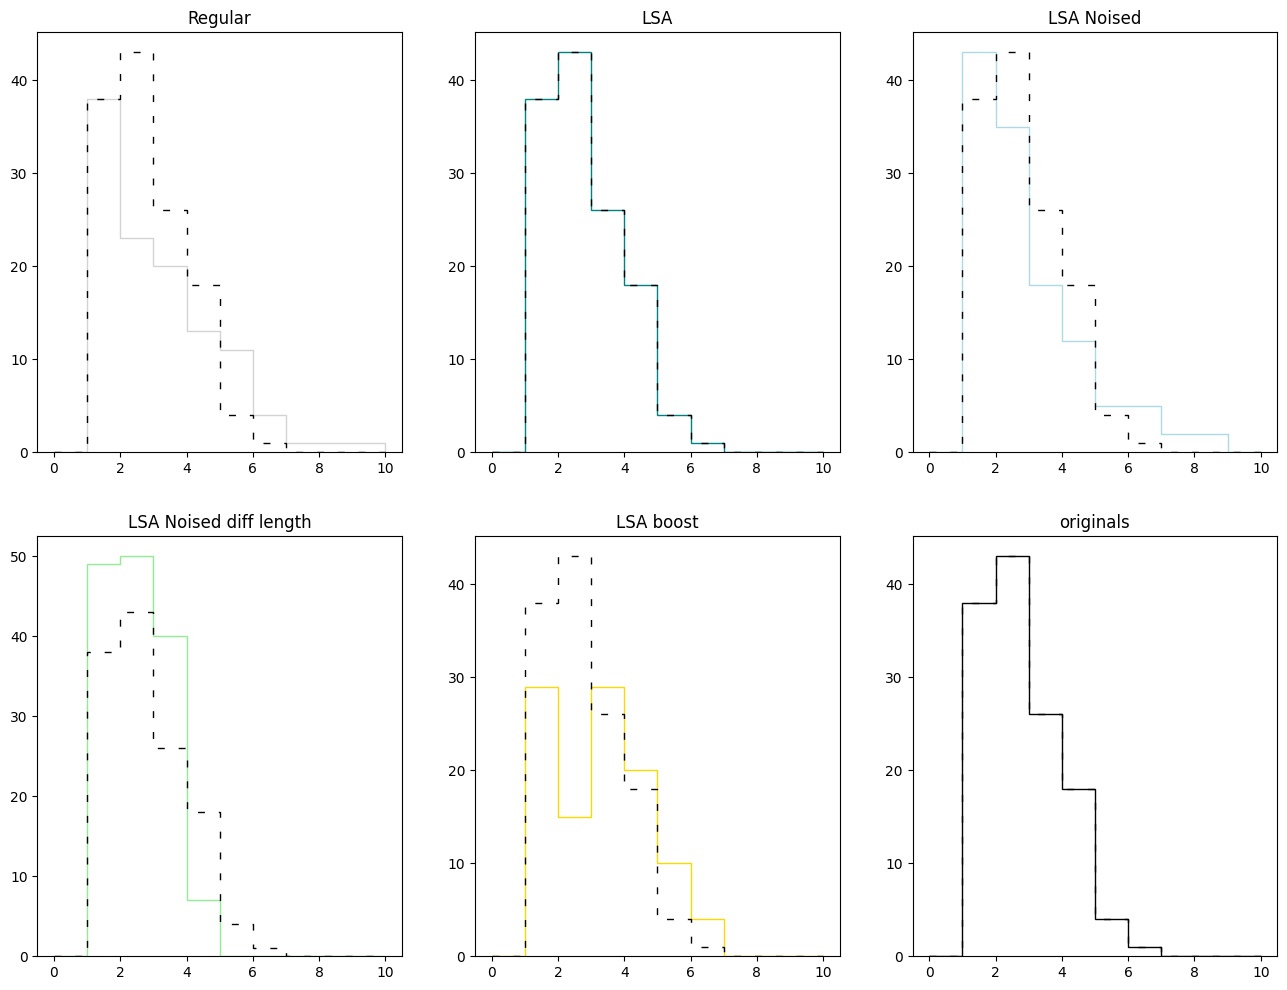

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12))  # 2 rows, 3 columns

datasets = [
    ('Regular', avatar_visit['patient_id_regular'].value_counts()),
    ('LSA', avatar_visit['patient_id_lsa'].value_counts()),
    ('LSA Noised', avatar_visit['patient_id_lsa_noised'].value_counts()),
    ('LSA Noised diff length', avatar_visit['patient_id_lsa_noised_diff_length'].value_counts()),
    ('LSA boost', avatar_visit['patient_id_lsa_boost'].value_counts()),
    ('originals', visit['patient_id'].value_counts())
]

for i, (label, data) in enumerate(datasets):
    ax = axs[i // 3, i % 3]
    ax.hist(np.array(data), bins=list(range(11)), histtype="step", label=label, color=map_color[label])
    ax.hist(np.array(datasets[5][1]), bins=list(range(11)), histtype="step", label=label, color=map_color["originals"], linestyle=(0, (5, 10)))
    ax.title.set_text(label)

plt.show()

We can observe the number of patients who have a certain number of visits. In the original data, 38 patients made one visit, 43 patients made 2 ...
We compare this distribution to the different methods :

- REGULAR : moderately preserves original distribution
- LSA : preserve exactly the same distribution (as expected)
- LSA Noised : realign the number of visits while preserving initial distribution
- LSA Noised DIFF LENGTH: realign the number of visits while preserving initial distribution
- LSA Boost : Doesn't preserve distribution very well

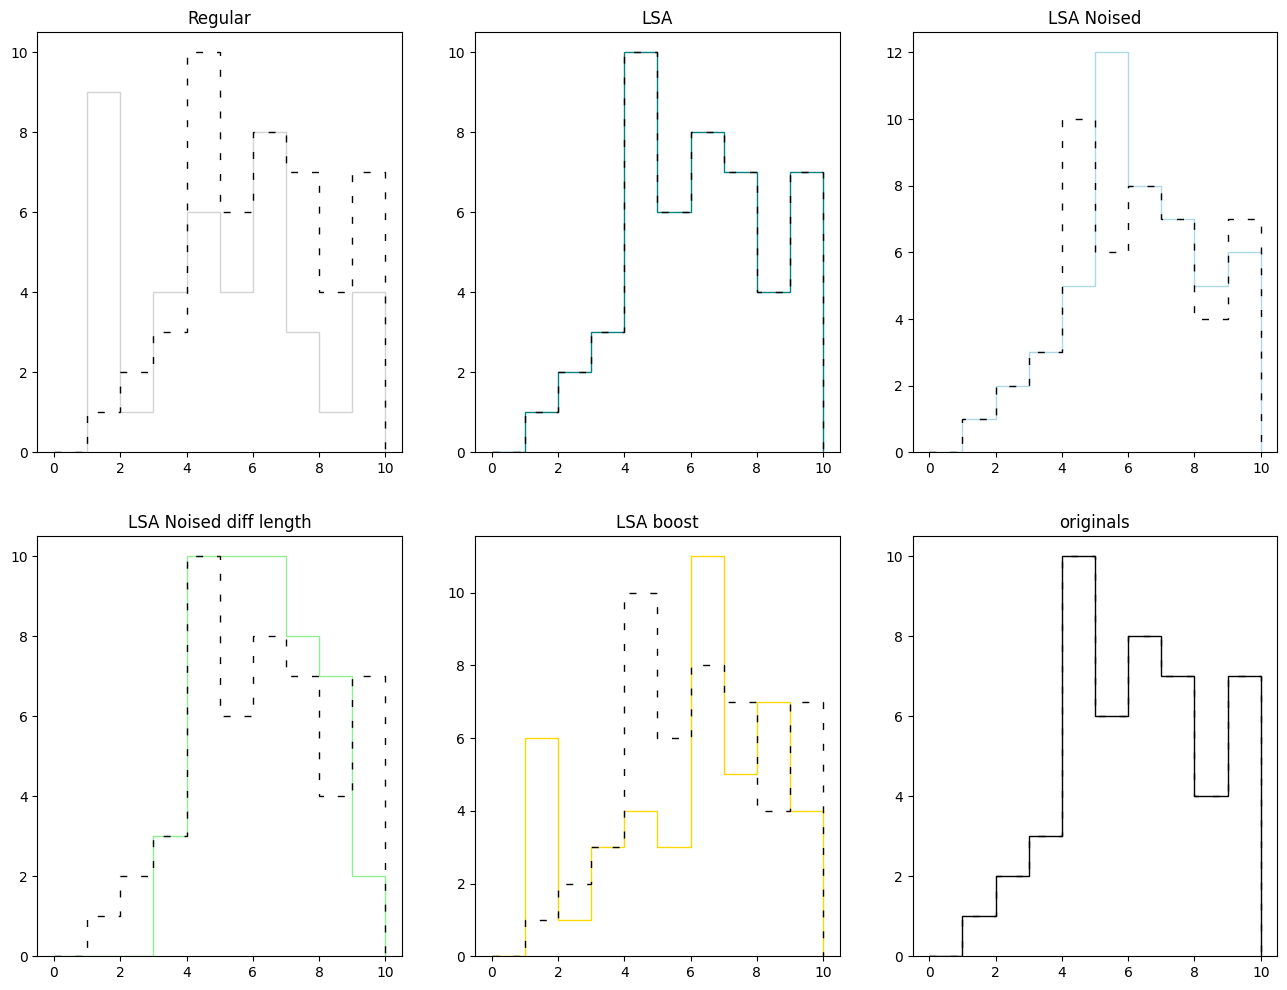

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12))  # 2 rows, 3 columns

datasets = [
    ('Regular', avatar_visit['doctor_id_regular'].value_counts()),
    ('LSA', avatar_visit['doctor_id_lsa'].value_counts()),
    ('LSA Noised', avatar_visit['doctor_id_lsa_noised'].value_counts()),
    ('LSA Noised diff length', avatar_visit['doctor_id_lsa_noised_diff_length'].value_counts()),
    ('LSA boost', avatar_visit['doctor_id_lsa_boost'].value_counts()),
    ('originals', visit['doctor_id'].value_counts())
]

for i, (label, data) in enumerate(datasets):
    ax = axs[i // 3, i % 3]
    ax.hist(np.array(data), bins=list(range(11)), histtype="step", label=label, color=map_color[label])
    ax.hist(np.array(datasets[5][1]), bins=list(range(11)), histtype="step", label=label, color=map_color["originals"], linestyle=(0, (5, 10)))
    ax.title.set_text(label)

# Move the legend outside the graph

plt.show()

We can observe the number of doctors who have a certain number of visits. In the original data, 1 doctor made one visit, 2 doctors made 2 ...
We compare this distribution to the different methods.

- REGULAR : Doesn't preserve distribution very well
- LSA : preserve exactly the same distribution (as expected)
- LSA Noised : realign the number of visits while moderatly preserving initial distribution
- LSA Noised DIFF LENGTH: realign the number of visits while preserving initial distribution
- LSA Boost : Doesn't preserve distribution very well

In [9]:
def visit_avat_flatten(iict):
    visit_avat_flat = avatar_visit.drop(columns=["gender", "height", "age", "weight", "job", "age_doctor"]).join(
        avatar_patient.set_index("patient_id"), on=f"patient_id_{iict}"
        )
    visit_avat_flat = visit_avat_flat.join(
            avatar_doctor.set_index("doctor_id"), on=f"doctor_id_{iict}"
        )
    visit_avat_flat['day_visit'] = pd.Categorical(visit_avat_flat['day_visit'], categories=day_order, ordered=True)
    visit_avat_flat=visit_avat_flat.sort_values('day_visit')
    return visit_avat_flat


In [10]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

#ORIGINALS
visit_after_bib['day_visit'] = pd.Categorical(visit_after_bib['day_visit'], categories=day_order, ordered=True)
visit_after_bib=visit_after_bib.sort_values('day_visit')

#REGULAR
visit_avat_flat_regular = visit_avat_flatten('regular')

#LSA
visit_avat_flat_lsa = visit_avat_flatten('lsa')

#LSA BOOST
visit_avat_flat_lsa_boost = visit_avat_flatten('lsa_boost')

#LSA NOISED
visit_avat_flat_lsa_noised = visit_avat_flatten('lsa_noised')

#LSA NOISED DIFF LENGTH
visit_avat_flat_lsa_noised_diff_length = visit_avat_flatten('lsa_noised_diff_length')


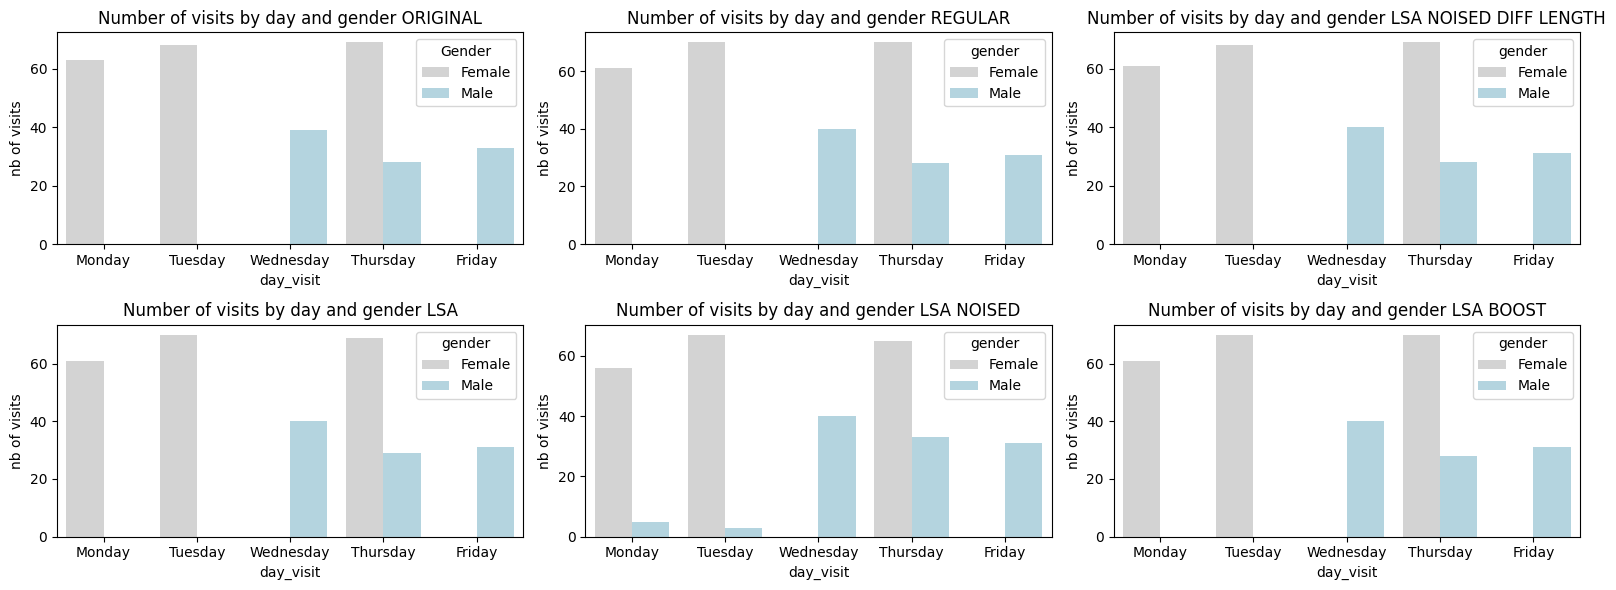

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(16, 6))
palette = {"Male": "lightblue", "Female": "lightgrey"}
sns.countplot(data=visit_after_bib,x='day_visit',hue="gender", ax=axs[0,0],palette=palette)
axs[0,0].set_ylabel("nb of visits")
axs[0,0].set_title("Number of visits by day and gender ORIGINAL")
axs[0,0].legend(title='Gender') 
sns.countplot(data=visit_avat_flat_regular,x='day_visit',hue="gender", ax=axs[0,1],palette=palette)
axs[0,1].set_ylabel("nb of visits")
axs[0,1].set_title("Number of visits by day and gender REGULAR")
sns.countplot(data=visit_avat_flat_lsa,x='day_visit',hue="gender", ax=axs[1,0],palette=palette)
axs[1,0].set_title("Number of visits by day and gender LSA") 
axs[1,0].set_ylabel("nb of visits")
sns.countplot(data=visit_avat_flat_lsa_noised,x='day_visit',hue="gender", ax=axs[1,1],palette=palette)
axs[1,1].set_title("Number of visits by day and gender LSA NOISED")
axs[1,1].set_ylabel("nb of visits")
sns.countplot(data=visit_avat_flat_lsa_noised_diff_length,x='day_visit',hue='gender', ax=axs[0,2],palette=palette)
axs[0,2].set_title("Number of visits by day and gender LSA NOISED DIFF LENGTH")
axs[0,2].set_ylabel("nb of visits")
sns.countplot(data=visit_avat_flat_lsa_boost,x='day_visit',hue='gender', ax=axs[1,2],palette=palette)
axs[1,2].set_title("Number of visits by day and gender LSA BOOST")
axs[1,2].set_ylabel("nb of visits")
plt.tight_layout()
plt.show()

For each method, the correlation and distribution appear to be well preserved

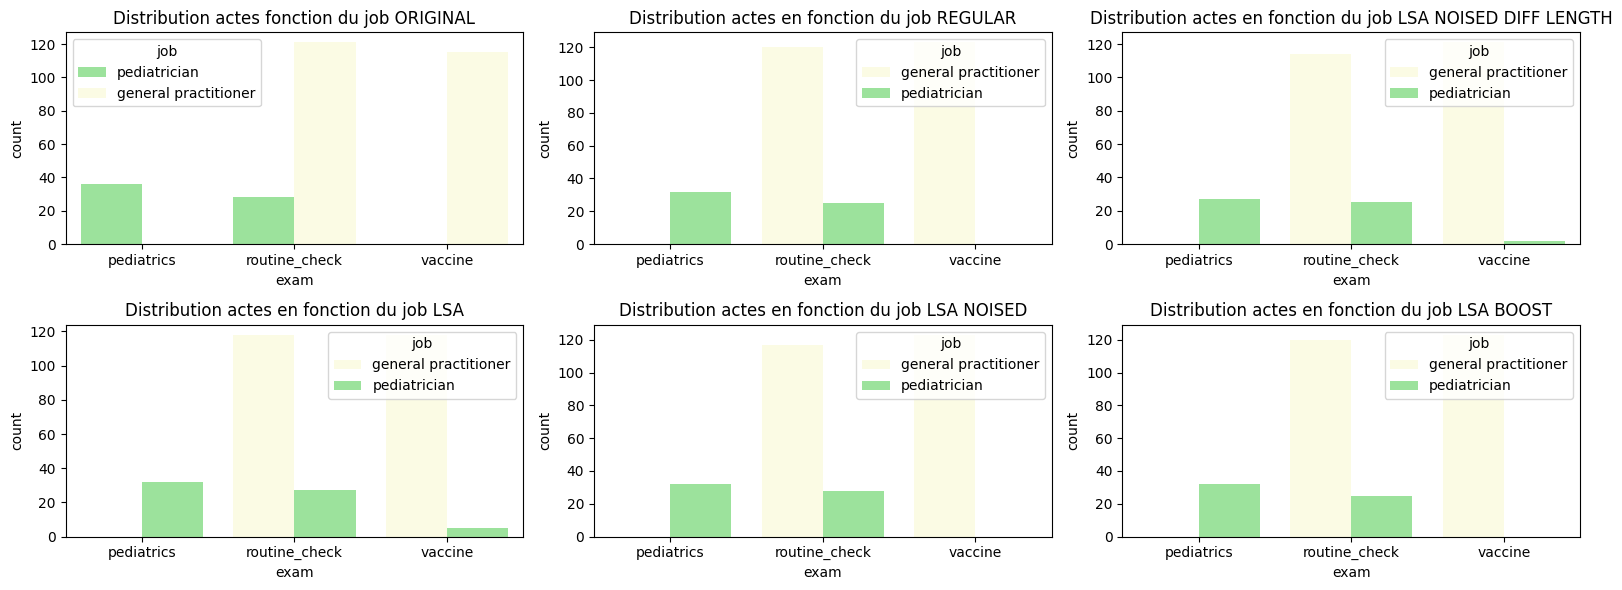

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(16, 6))
palette = {"pediatrician": "lightgreen", "general practitioner": "lightyellow"}
sns.countplot(data=visit_after_bib.sort_values('exam'),x='exam',hue="job",ax=axs[0,0],palette=palette)
axs[0,0].set_title("Distribution actes fonction du job ORIGINAL")
axs[0,0].legend(title='job') 
sns.countplot(data=visit_avat_flat_regular.sort_values('exam'),x='exam',hue="job", ax=axs[0,1],palette=palette)
axs[0,1].set_title("Distribution actes en fonction du job REGULAR")
sns.countplot(data=visit_avat_flat_lsa.sort_values('exam'),x='exam',hue="job", ax=axs[1,0],palette=palette)
axs[1,0].set_title("Distribution actes en fonction du job LSA")
sns.countplot(data=visit_avat_flat_lsa_noised.sort_values('exam'),x='exam',hue="job", ax=axs[1,1],palette=palette)
axs[1,1].set_title("Distribution actes en fonction du job LSA NOISED")
sns.countplot(data=visit_avat_flat_lsa_noised_diff_length.sort_values('exam'),x='exam',hue="job", ax=axs[0,2],palette=palette)
axs[0,2].set_title("Distribution actes en fonction du job LSA NOISED DIFF LENGTH")
sns.countplot(data=visit_avat_flat_lsa_boost.sort_values('exam'),x='exam',hue="job", ax=axs[1,2],palette=palette)
axs[1,2].set_title("Distribution actes en fonction du job LSA BOOST")
plt.tight_layout()
plt.show()

For each method, the correlation and distribution appear to be well preserved

## Correlation

In this section, we'll see how well the correlation between the original and the avatars is preserved.
We use the visit table with all the information from the parent tables

In [13]:
avatar_visit_regular=avatar_visit[['visit_id','patient_id_regular','doctor_id_regular','day_visit','exam']]
avatar_visit_regular.columns=['visit_id','patient_id','doctor_id','day_visit','exam']

avatar_visit_lsa=avatar_visit[['visit_id','patient_id_lsa','doctor_id_lsa','day_visit','exam']]
avatar_visit_lsa.columns=['visit_id','patient_id','doctor_id','day_visit','exam']

avatar_visit_lsa_boost=avatar_visit[['visit_id','patient_id_lsa_boost','doctor_id_lsa_boost','day_visit','exam']]
avatar_visit_lsa_boost.columns=['visit_id','patient_id','doctor_id','day_visit','exam']

avatar_visit_lsa_noised=avatar_visit[['visit_id','patient_id_lsa_noised','doctor_id_lsa_noised','day_visit','exam']]
avatar_visit_lsa_noised.columns=['visit_id','patient_id','doctor_id','day_visit','exam']

avatar_visit_lsa_noised_diff_length=avatar_visit[['visit_id','patient_id_lsa_noised_diff_length','doctor_id_lsa_noised_diff_length','day_visit','exam']]
avatar_visit_lsa_noised_diff_length.columns=['visit_id','patient_id','doctor_id','day_visit','exam']

In [14]:
merge=visit.merge(patient, on='patient_id').merge(doctor,on='doctor_id')
styled_ori = merge.drop(columns=['patient_id','visit_id','doctor_id','job','exam','day_visit','gender']).corr().style.background_gradient(cmap='RdYlBu_r')
print("ORIGINAL")
styled_ori

ORIGINAL


,height,age,weight,age_doctor
height,1.000000,-0.417702,0.813301,-0.060965
age,-0.417702,1.000000,-0.341995,0.088443
weight,0.813301,-0.341995,1.000000,-0.055622
age_doctor,-0.060965,0.088443,-0.055622,1.000000


In [15]:
#REGULAR
merge_regular=avatar_visit_regular.merge(avatar_patient, on='patient_id').merge(avatar_doctor,on='doctor_id')
styled_regular = merge_regular.drop(columns=['patient_id','visit_id','doctor_id','job','exam','day_visit','gender']).corr().style.background_gradient(cmap='RdYlBu_r')
print("REGULAR")
styled_regular

REGULAR


,height,age,weight,age_doctor
height,1.000000,-0.590642,0.894514,0.046109
age,-0.590642,1.000000,-0.553742,0.071529
weight,0.894514,-0.553742,1.000000,0.070594
age_doctor,0.046109,0.071529,0.070594,1.000000


In [16]:
#LSA
merge_lsa=avatar_visit_lsa.merge(avatar_patient, on='patient_id').merge(avatar_doctor,on='doctor_id')
styled_lsa = merge_lsa.drop(columns=['patient_id','visit_id','doctor_id','job','exam','day_visit','gender']).corr().style.background_gradient(cmap='RdYlBu_r')
print("LSA")
styled_lsa

LSA


,height,age,weight,age_doctor
height,1.000000,-0.507577,0.897467,0.021048
age,-0.507577,1.000000,-0.484721,0.058949
weight,0.897467,-0.484721,1.000000,0.030283
age_doctor,0.021048,0.058949,0.030283,1.000000


In [17]:
#LSA BOOST
merge_lsa_boost=avatar_visit_lsa_boost.merge(avatar_patient, on='patient_id').merge(avatar_doctor,on='doctor_id')
styled_lsa_boost = merge_lsa_boost.drop(columns=['patient_id','visit_id','doctor_id','job','exam','day_visit','gender']).corr().style.background_gradient(cmap='RdYlBu_r')
print("LSA BOOST")
styled_lsa_boost

LSA BOOST


,height,age,weight,age_doctor
height,1.000000,-0.587010,0.894502,0.055936
age,-0.587010,1.000000,-0.560391,0.048857
weight,0.894502,-0.560391,1.000000,0.068350
age_doctor,0.055936,0.048857,0.068350,1.000000


In [18]:
#LSA NOISED
merge_lsa_noised=avatar_visit_lsa_noised.merge(avatar_patient, on='patient_id').merge(avatar_doctor,on='doctor_id')
styled_lsa_noised = merge_lsa_noised.drop(columns=['patient_id','visit_id','doctor_id','job','exam','day_visit','gender']).corr().style.background_gradient(cmap='RdYlBu_r')
print("LSA NOISED")
styled_lsa_noised

LSA NOISED


,height,age,weight,age_doctor
height,1.000000,-0.527746,0.914344,0.059705
age,-0.527746,1.000000,-0.506675,0.004574
weight,0.914344,-0.506675,1.000000,0.103318
age_doctor,0.059705,0.004574,0.103318,1.000000


In [19]:
#LSA NOISED DIFF LENGTH
merge_lsa_noised_diff_length=avatar_visit_lsa_noised_diff_length.merge(avatar_patient, on='patient_id').merge(avatar_doctor,on='doctor_id').drop(columns=['patient_id','visit_id','doctor_id','job','exam','day_visit','gender'])
styled_lsa_noised_diff_length = merge_lsa_noised_diff_length.corr().style.background_gradient(cmap='RdYlBu_r')
print("LSA NOISED DIFF LENGTH")
styled_lsa_noised_diff_length

LSA NOISED DIFF LENGTH


,height,age,weight,age_doctor
height,1.000000,-0.533649,0.908632,0.032529
age,-0.533649,1.000000,-0.500978,0.006719
weight,0.908632,-0.500978,1.000000,0.080794
age_doctor,0.032529,0.006719,0.080794,1.000000


For each method, the correlation is well preserved

## How different are the methods ?

In [20]:
col=['regular','lsa','lsa_boost','lsa_noised','lsa_noised_diff_length']
row=['patient','doctor']

for c in col :
    avatar_visit[f"same_patient_{c}"] = avatar_visit[f"patient_id_{c}"] == visit["patient_id"]
    avatar_visit[f"same_doctor_{c}"] = avatar_visit[f"doctor_id_{c}"] == visit["doctor_id"]
    for c1 in col:
        if c1!=c:
            avatar_visit[f"same_patient_{c}_{c1}"] = avatar_visit[f"patient_id_{c}"] == avatar_visit[f"patient_id_{c1}"]
            avatar_visit[f"same_doctor_{c}_{c1}"] = avatar_visit[f"doctor_id_{c}"] == avatar_visit[f"doctor_id_{c1}"]

table=pd.DataFrame(index=['REGULAR','LSA','LSA BOOST','LSA NOISED','LSA NOISED DIFF LENGTH'])

for c,i in zip(col,table.index):
    table.loc[i,'nb_visites_patient']=avatar_visit[f'patient_id_{c}'].count()
    table.loc[i,'nb_visites_doctor']=avatar_visit[f'doctor_id_{c}'].count()
    table.loc[i,'nb_patient']=avatar_visit[f'patient_id_{c}'].nunique()
    table.loc[i,'nb_doctor']=avatar_visit[f'doctor_id_{c}'].nunique()
    for c1 in col:
        if c1!=c:
            table.loc[i,f'nb_patient_same_{c1}']=avatar_visit[f'same_patient_{c}_{c1}'].sum()
            table.loc[i,f'nb_doctor_same_{c1}']=avatar_visit[f'same_doctor_{c}_{c1}'].sum()
table_patient=table[['nb_visites_patient','nb_patient','nb_patient_same_regular','nb_patient_same_lsa','nb_patient_same_lsa_boost','nb_patient_same_lsa_noised','nb_patient_same_lsa_noised_diff_length']]
table_doctor=table[['nb_visites_doctor','nb_doctor','nb_doctor_same_regular','nb_doctor_same_lsa','nb_doctor_same_lsa_boost','nb_doctor_same_lsa_noised','nb_doctor_same_lsa_noised_diff_length']]

In [21]:
table_patient[['nb_visites_patient','nb_patient']]

,nb_visites_patient,nb_patient
REGULAR,300.0,112.0
LSA,300.0,130.0
LSA BOOST,300.0,107.0
LSA NOISED,300.0,122.0
LSA NOISED DIFF LENGTH,297.0,146.0


In the original data, we have 150 patients and 130 of them have at least one visit.

- REGULAR : the number of patients with at least one visit in the avatarized dataset is **lower** than the number of patients with at least one visit in the original dataset (after anonymization, less patients are assigned to a visit -> some patients have more visits).
- LSA : keeps the **same** number of patients with at least one visit
- LSA BOOST : the number of patients with at least one visit in the avatarized visit table is **lower** than the number of patients with at least one visit in the original dataset (after anonymization, more patients are not assigned to any visit)
- LSA NOISED : the number of patients with at least one visit in the avatarized visit table is **higher** than the number of patients with at least one visit in the original dataset (after anonymization, patients who originally had no visits now have at least one)
- LSA NOISED DIFF LENGTH : the number of patients with at least one visit in the avatarized visit table is **higher** than the number of patients with at least one visit in the original dataset (after anonymization, patients who originally had no visits now have at least one).

In [22]:
table_patient.drop(columns=['nb_visites_patient','nb_patient']).style.background_gradient(cmap='BuGn', vmin=0,vmax=300)

,nb_patient_same_regular,nb_patient_same_lsa,nb_patient_same_lsa_boost,nb_patient_same_lsa_noised,nb_patient_same_lsa_noised_diff_length
REGULAR,nan,118.000000,214.000000,8.000000,14.000000
LSA,118.000000,nan,142.000000,13.000000,16.000000
LSA BOOST,214.000000,142.000000,nan,7.000000,11.000000
LSA NOISED,8.000000,13.000000,7.000000,nan,145.000000
LSA NOISED DIFF LENGTH,14.000000,16.000000,11.000000,145.000000,nan


The REGULAR, LSA and LSA Boost methods often associated patients with the same visit.
 
LSA NOISED & LSA NOISED DIFF LENGTH methods often associated patients with the same visit.

In [23]:
table_doctor[['nb_visites_doctor','nb_doctor']]

,nb_visites_doctor,nb_doctor
REGULAR,300.0,47.0
LSA,300.0,50.0
LSA BOOST,300.0,49.0
LSA NOISED,300.0,50.0
LSA NOISED DIFF LENGTH,289.0,50.0


In the original data, we have 50 doctors and all of them have at least one visit.

- REGULAR : the number of doctors with at least one visit in the avatarized dataset is **lower** than the number of doctors with at least one visit in the original dataset (after anonymization, less doctors are assigned to a visit -> some doctors have more visits).
- LSA,LSA NOISED, LSA NOISED DIFF LENGTH : keeps the **same** number of doctors with at least one visit

In [24]:
table_doctor.drop(columns=['nb_visites_doctor','nb_doctor']).style.background_gradient(cmap='BuGn', vmin=0,vmax=300)

,nb_doctor_same_regular,nb_doctor_same_lsa,nb_doctor_same_lsa_boost,nb_doctor_same_lsa_noised,nb_doctor_same_lsa_noised_diff_length
REGULAR,nan,90.000000,160.000000,33.000000,35.000000
LSA,90.000000,nan,107.000000,28.000000,26.000000
LSA BOOST,160.000000,107.000000,nan,35.000000,30.000000
LSA NOISED,33.000000,28.000000,35.000000,nan,86.000000
LSA NOISED DIFF LENGTH,35.000000,26.000000,30.000000,86.000000,nan


The REGULAR, LSA and LSA Boost methods often associated patients with the same visit.
 
LSA NOISED & LSA NOISED DIFF LENGTH methods often associated patients with the same visit.

## Comparaison with the original data

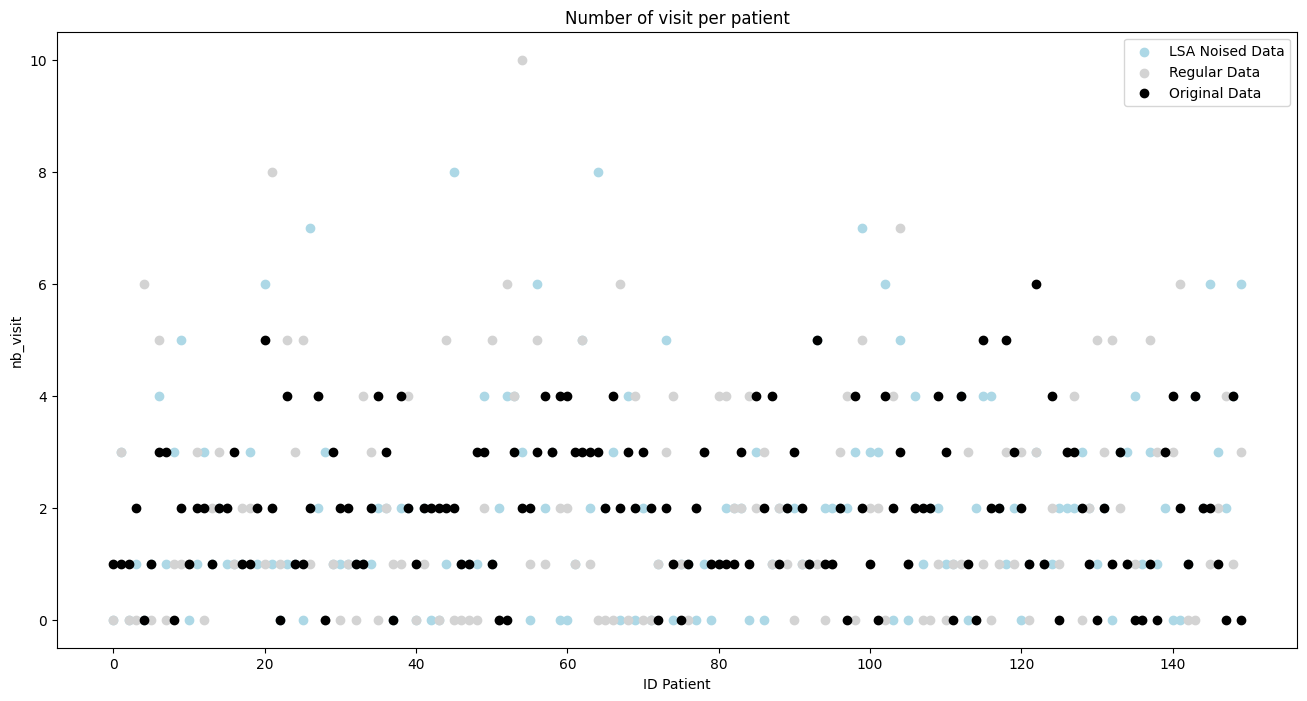

In [25]:
visits_per_patient_lsa_noised = merge_lsa_noised.groupby('patient_id').size().reset_index().rename(columns={0: 'nb_visits_lsa_noised'})
visits_per_patient_regular = merge_regular.groupby('patient_id').size().reset_index().rename(columns={0: 'nb_visits_regular'})
#visits_per_patient_lsa = merge_regular.groupby('patient_id').size().reset_index().rename(columns={0: 'nb_visits_regular'})

visits_per_patient_original = merge.groupby('patient_id').size().reset_index().rename(columns={0: 'nb_visits_original'})

# Fusionner les deux DataFrames sur la colonne 'patient_id'
merged_visits = visits_per_patient_lsa_noised.merge(visits_per_patient_regular, on='patient_id', how='outer').fillna(0)
merged_visits = merged_visits.merge(visits_per_patient_original, on='patient_id', how='outer').fillna(0)
# Tracer les nombres de visites par patient pour les deux ensembles de données sur le même graphique
plt.figure(figsize=(16, 8))
plt.scatter(merged_visits['patient_id'], merged_visits['nb_visits_lsa_noised'], label='LSA Noised Data',color=map_color['LSA Noised'])
plt.scatter(merged_visits['patient_id'], merged_visits['nb_visits_regular'], label='Regular Data',color=map_color['Regular'])
plt.scatter(merged_visits['patient_id'], merged_visits['nb_visits_original'], label='Original Data',color=map_color['originals'])
plt.title('Number of visit per patient')
plt.xlabel('ID Patient')
plt.ylabel('nb_visit')
plt.legend()
plt.show()

We can observe the number of visit per patient for the regular and LSA Noised method 

In [26]:
table=[]
for i in ['lsa_noised', 'regular']:
    merged_visits[f'diff_{i}'] = abs(merged_visits[f'nb_visits_{i}'] - merged_visits['nb_visits_original'])
    min_diff = abs(merged_visits[f'diff_{i}']).min()
    max_diff = abs(merged_visits[f'diff_{i}']).max()
    mean_diff = abs(merged_visits[f'diff_{i}']).mean()
    same_visits = merged_visits[f'diff_{i}'].eq(0).sum()
    bins = [ 0, 2, 4, float('inf')]
    labels = [ '0_2', '2_4', '4+']
    merged_visits[f'diff_{i}_category'] = pd.cut(merged_visits[f'diff_{i}'], bins=bins, labels=labels)
    category_counts = merged_visits[f'diff_{i}_category'].value_counts().reindex(labels, fill_value=0)
    
    table.append({
        'IICT': i.capitalize(),
        'min': min_diff,
        'max': max_diff,
        'mean': mean_diff,
        'same_visit_gap_0_2': category_counts['0_2'],
        'same_visit_gap_2_4': category_counts['2_4'],
        'same_visit_gap_4+': category_counts['4+'],
        'same_visit_as_original': same_visits,
        'same_visit_as_original_%': same_visits/3,
    })

# Créer un DataFrame à partir de la liste de dictionnaires
summary_df = pd.DataFrame(table)
summary_df.set_index('IICT', inplace=True)
# Afficher le DataFrame
summary_df


,min,max,mean,same_visit_gap_0_2,same_visit_gap_2_4,same_visit_gap_4+,same_visit_as_original,same_visit_as_original_%
IICT,,,,,,,,
Lsa_noised,0.0,6.0,1.453333,94,17,5,34,11.333333
Regular,0.0,8.0,1.880000,83,40,5,22,7.333333


LSA Noised has a smaller average difference between the number of visits in the original data and with the LSA Noised method than the regular method.
The LSA Noised method assigned around 15% of patients the same number of visits as the original data.

The regular method has bigger gap with the original data than the LSA noised method.

## Privacy metrics 

In this section we will apply the privacy metrics on the different methods

### Get the privacy metrics

In [27]:

def get_column_direct_match_protection(records,avatars):
    all_raw_match = {}
    all_protection_values = {}
    for col in avatars.columns:
        # Sort column values so that they are ordered in the same way.
        # If there are direct identifiers, similar values will be at the same index even
        # if the data was shuffled.
        originals_vals = records[col]#.sort_values()
        avatars_vals = avatars[col]#.sort_values()

        # get number of direct matches
        matches = np.sum([x == y for x, y in zip(originals_vals, avatars_vals)])
        all_raw_match[col] = matches / len(records)

        # weight the percentage of direct matches based on number of unique values of the column
        all_protection_values[col] = (
            1 - (matches * len(set(avatars_vals)) / (len(records) ** 2))
        ) * 100



    return all_protection_values

In [28]:
# TABLE LINKS
doctor_ref = TableReference(
    dataset_id=dataset_doctor.id,
    is_individual_level=True,
)
patient_ref = TableReference(
    dataset_id=dataset_patient.id,
    is_individual_level=True,
)
visit_ref = TableReference(
    dataset_id=dataset_visit.id,
    is_individual_level=False,
)


table_links = [
    TableLink(
        parent_table=patient_ref,
        child_table=visit_ref,
        link_method="bottom_projection",
        parent_link_key="patient_id",
        child_link_key="patient_id",
    ),
    TableLink(
        parent_table=doctor_ref,
        child_table=visit_ref,
        link_method="bottom_projection",
        parent_link_key="doctor_id",
        child_link_key="doctor_id",
    ),
]

In [29]:
## AVATAR PATIENT
avatar_patient=avatar_patient[['patient_id','gender','height','age','weight']]
dataset_avatar_patient = client.pandas_integration.upload_dataframe(avatar_patient,
                                                                        name="patient_avat",
                                                                   identifier_variables=["patient_id"])

## AVATAR DOCTOR 
avatar_doctor=avatar_doctor[['doctor_id','job','age_doctor']]
dataset_avatar_doctor = client.pandas_integration.upload_dataframe(avatar_doctor,
                                                                        name="doctor_avat",
                                                                        identifier_variables=["doctor_id"])

## AVATAR VISIT 

# REGULAR
dataset_avatar_visit_regular = client.pandas_integration.upload_dataframe(avatar_visit_regular,
                                                                        name="visit_avat",
                                                                        identifier_variables=["visit_id","patient_id","doctor_id"])

#LSA
dataset_avatar_visit_lsa = client.pandas_integration.upload_dataframe(avatar_visit_lsa,
                                                                        name="visit_avat",
                                                                        identifier_variables=["visit_id","patient_id","doctor_id"])

#LSA BOOST
dataset_avatar_visit_lsa_boost = client.pandas_integration.upload_dataframe(avatar_visit_lsa_boost,
                                                                        name="visit_avat",
                                                                        identifier_variables=["visit_id","patient_id","doctor_id"])


#LSA NOISED
dataset_avatar_visit_lsa_noised = client.pandas_integration.upload_dataframe(avatar_visit_lsa_noised,
                                                                        name="visit_avat",
                                                                        identifier_variables=["visit_id","patient_id","doctor_id"])

# LSA NOISED DIFF LENGTH
# dataset_avatar_visit_lsa_noised_diff_length = client.pandas_integration.upload_dataframe(avatar_visit_lsa_noised_diff_length,
#                                                                         name="visit_avat",
#                                                                         identifier_variables=["visit_id","patient_id","doctor_id"])




In [30]:
### PRIVACY METRICS 
def calculate_privacy_metric(dataset_avatar_visit):
    privacy_parameters = parameters = [
        BasePrivacyMetricsParameters(
            original_id=dataset_patient.id,
            unshuffled_avatars_id=dataset_avatar_patient.id,
        ),
        BasePrivacyMetricsParameters(
            original_id=dataset_doctor.id,
            unshuffled_avatars_id=dataset_avatar_doctor.id,
        ),
        BasePrivacyMetricsParameters(
            original_id=dataset_visit.id,
            unshuffled_avatars_id=dataset_avatar_visit.id,
        ),
    ]

    privacy_job = client.jobs.create_privacy_metrics_multi_table_job(
        PrivacyMetricsMultiTableJobCreate(
            parameters=PrivacyMetricsMultiTableParameters(
                table_links=table_links,
                model_config=None,
                table_parameters=privacy_parameters,
            )
        )
    )

    privacy_job = client.jobs.get_privacy_metrics_multi_table_job(privacy_job.id, timeout=1000)
    return privacy_job


# REGULAR
privacy_job_regular = calculate_privacy_metric(dataset_avatar_visit_regular)

#LSA
privacy_job_lsa = calculate_privacy_metric(dataset_avatar_visit_lsa)

#LSA BOOST
privacy_job_lsa_boost = calculate_privacy_metric(dataset_avatar_visit_lsa_boost)

# LSA NOISED 
privacy_job_lsa_noised = calculate_privacy_metric(dataset_avatar_visit_lsa_noised)


# LSA NOISED DIFF LENGTH
# privacy_job_lsa_noised_diff_length = calculate_privacy_metric(dataset_avatar_visit_lsa_noised_diff_length)

ValidationError: 16 validation errors for PrivacyMetricsMultiTableJob
result.details.0.PrivacyMetricsPerMultiTableDataset.dataset_name
  Field required [type=missing, input_value={'hidden_rate': 84.0, 'lo...ion_type': 'standalone'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.6/v/missing
result.details.0.PrivacyMetricsPerTimeSeriesDataset.metrics_type
  Input should be 'time_series' [type=literal_error, input_value='multi_table', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/literal_error
result.details.1.PrivacyMetricsPerMultiTableDataset.dataset_name
  Field required [type=missing, input_value={'hidden_rate': 100.0, 'l...o_bottom_id_propagated'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.6/v/missing
result.details.1.PrivacyMetricsPerTimeSeriesDataset.metrics_type
  Input should be 'time_series' [type=literal_error, input_value='multi_table', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/literal_error
result.details.2.PrivacyMetricsPerMultiTableDataset.dataset_name
  Field required [type=missing, input_value={'hidden_rate': 96.0, 'lo...ype': 'to_top_enriched'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.6/v/missing
result.details.2.PrivacyMetricsPerTimeSeriesDataset.metrics_type
  Input should be 'time_series' [type=literal_error, input_value='multi_table', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/literal_error
result.details.3.PrivacyMetricsPerMultiTableDataset.dataset_name
  Field required [type=missing, input_value={'hidden_rate': 93.33, 'l...ion_type': 'standalone'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.6/v/missing
result.details.3.PrivacyMetricsPerTimeSeriesDataset.metrics_type
  Input should be 'time_series' [type=literal_error, input_value='multi_table', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/literal_error
result.details.4.PrivacyMetricsPerMultiTableDataset.dataset_name
  Field required [type=missing, input_value={'hidden_rate': 100.0, 'l...o_bottom_id_propagated'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.6/v/missing
result.details.4.PrivacyMetricsPerTimeSeriesDataset.metrics_type
  Input should be 'time_series' [type=literal_error, input_value='multi_table', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/literal_error
result.details.5.PrivacyMetricsPerMultiTableDataset.dataset_name
  Field required [type=missing, input_value={'hidden_rate': 94.67, 'l...ype': 'to_top_enriched'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.6/v/missing
result.details.5.PrivacyMetricsPerTimeSeriesDataset.metrics_type
  Input should be 'time_series' [type=literal_error, input_value='multi_table', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/literal_error
result.details.6.PrivacyMetricsPerMultiTableDataset.dataset_name
  Field required [type=missing, input_value={'hidden_rate': 96.333333..._type': 'full_enriched'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.6/v/missing
result.details.6.PrivacyMetricsPerTimeSeriesDataset.metrics_type
  Input should be 'time_series' [type=literal_error, input_value='multi_table', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/literal_error
result.details.7.PrivacyMetricsPerMultiTableDataset.dataset_name
  Field required [type=missing, input_value={'hidden_rate': 98.0, 'lo..._type': 'full_enriched'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.6/v/missing
result.details.7.PrivacyMetricsPerTimeSeriesDataset.metrics_type
  Input should be 'time_series' [type=literal_error, input_value='multi_table', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/literal_error

In [ ]:
def to_df_metrics(privacy_job):
    index = ['standalone_doctor.doctor_id', 'standalone_patient.patient_id', 
                      'to_bottom_id_propagated_doctor.doctor_id', 'to_bottom_id_propagated_patient.patient_id',
                      'to_top_enriched_doctor.doctor_id', 'to_top_enriched_patient.patient_id',
                      'full_enriched_doctor.doctor_id','full_enriched_patient.patient_id']
    data=privacy_job.result.details
    data_dict = {
        'Hidden Rate': [d.hidden_rate for d in data],
        'Local Cloaking': [d.local_cloaking for d in data],
        'Distance to Closest': [d.distance_to_closest for d in data],
        'Closest Distances Ratio': [d.closest_distances_ratio for d in data],
        'Column Direct Match Protection': [d.column_direct_match_protection for d in data],
        'Categorical Hidden Rate': [d.categorical_hidden_rate for d in data],
        'Row Direct Match Protection': [d.row_direct_match_protection for d in data],
        'Table': [d.computation_type.name + "_" +str(d.individual_identifier_variable ) for d in data],
        'dataset_name': [d.dataset_name for d in data]

    }

    df_regular = pd.DataFrame(data_dict)
    df_regular.set_index('Table', inplace=True)
    df_regular = df_regular.reindex(index)
    return df_regular
    


#REGULAR
df_regular=to_df_metrics(privacy_job_regular)


#LSA
df_lsa=to_df_metrics(privacy_job_lsa)

#LSA
df_lsa_boost=to_df_metrics(privacy_job_lsa_boost)

#LSA NOISED
df_lsa_noised=to_df_metrics(privacy_job_lsa_noised)

#LSA NOISED DIFF LENGTH 
# df_lsa_noised_diff_length=to_df_metrics(privacy_job_lsa_noised_diff_length)

#TARGETS
data_dict = {
        'Hidden Rate':90,
        'Local Cloaking': 5,
        'Distance to Closest': 0.2,
        'Closest Distances Ratio': 0.3,
        'Column Direct Match Protection':50,
        'Categorical Hidden Rate': 90,
        'Row Direct Match Protection': 90,
        'Table': ['target']

    }

df_targets = pd.DataFrame(data_dict)


### Compare the privacy metrics

In [ ]:
df_targets

,Hidden Rate,Local Cloaking,Distance to Closest,Closest Distances Ratio,Column Direct Match Protection,Categorical Hidden Rate,Row Direct Match Protection,Table
0,90,5,0.2,0.3,50,90,90,target


In [ ]:
df_regular

,Hidden Rate,Local Cloaking,Distance to Closest,Closest Distances Ratio,Column Direct Match Protection,Categorical Hidden Rate,Row Direct Match Protection,dataset_name
Table,,,,,,,,
standalone_doctor.doctor_id,94.000000,3.0,0.019110,0.46690,96.080000,100.00,100.0,doctor
standalone_patient.patient_id,91.330000,7.0,0.196600,0.70580,98.670000,100.00,100.0,patient
to_bottom_id_propagated_doctor.doctor_id,100.000000,22.0,0.000000,1.00000,98.444444,100.00,0.0,visit
to_bottom_id_propagated_patient.patient_id,100.000000,34.5,0.000000,1.00000,98.444444,100.00,0.0,visit
to_top_enriched_doctor.doctor_id,90.000000,17.5,0.701000,0.73680,96.080000,83.33,100.0,doctor
to_top_enriched_patient.patient_id,95.330000,34.0,0.498900,0.73160,98.560000,100.00,100.0,patient
full_enriched_doctor.doctor_id,94.333333,15.0,0.455985,0.72021,98.444444,100.00,100.0,visit
full_enriched_patient.patient_id,98.666667,28.0,0.455985,0.72021,98.444444,100.00,100.0,visit


In [ ]:
df_lsa_noised

,Hidden Rate,Local Cloaking,Distance to Closest,Closest Distances Ratio,Column Direct Match Protection,Categorical Hidden Rate,Row Direct Match Protection,dataset_name
Table,,,,,,,,
standalone_doctor.doctor_id,94.000000,3.0,0.019110,0.466900,96.080000,100.0,100.0,doctor
standalone_patient.patient_id,91.330000,7.0,0.196600,0.705800,98.670000,100.0,100.0,patient
to_bottom_id_propagated_doctor.doctor_id,100.000000,26.0,0.000000,1.000000,98.444444,100.0,0.0,visit
to_bottom_id_propagated_patient.patient_id,100.000000,35.0,0.000000,1.000000,98.444444,100.0,0.0,visit
to_top_enriched_doctor.doctor_id,88.000000,12.5,0.463800,0.653900,95.800000,100.0,100.0,doctor
to_top_enriched_patient.patient_id,91.330000,21.0,0.485700,0.733600,98.290000,100.0,100.0,patient
full_enriched_doctor.doctor_id,96.000000,15.0,0.638166,0.800565,98.444444,100.0,100.0,visit
full_enriched_patient.patient_id,97.333333,27.0,0.638166,0.800565,98.444444,100.0,100.0,visit


In [ ]:
df_lsa

,Hidden Rate,Local Cloaking,Distance to Closest,Closest Distances Ratio,Column Direct Match Protection,Categorical Hidden Rate,Row Direct Match Protection,dataset_name
Table,,,,,,,,
standalone_doctor.doctor_id,94.000000,3.0,0.019110,0.466900,96.080000,100.0,100.0,doctor
standalone_patient.patient_id,91.330000,7.0,0.196600,0.705800,98.670000,100.0,100.0,patient
to_bottom_id_propagated_doctor.doctor_id,100.000000,28.0,0.000000,1.000000,98.444444,100.0,0.0,visit
to_bottom_id_propagated_patient.patient_id,100.000000,37.0,0.000000,1.000000,98.444444,100.0,0.0,visit
to_top_enriched_doctor.doctor_id,88.000000,12.5,0.503400,0.742100,78.000000,100.0,100.0,doctor
to_top_enriched_patient.patient_id,83.330000,11.5,0.430900,0.658300,96.160000,100.0,100.0,patient
full_enriched_doctor.doctor_id,95.333333,13.0,0.508708,0.730554,98.444444,100.0,100.0,visit
full_enriched_patient.patient_id,95.000000,20.0,0.508708,0.730554,98.444444,100.0,100.0,visit


In [ ]:
df_lsa_boost

,Hidden Rate,Local Cloaking,Distance to Closest,Closest Distances Ratio,Column Direct Match Protection,Categorical Hidden Rate,Row Direct Match Protection,dataset_name
Table,,,,,,,,
standalone_doctor.doctor_id,94.000000,3.0,0.019110,0.466900,96.080000,100.00,100.0,doctor
standalone_patient.patient_id,91.330000,7.0,0.196600,0.705800,98.670000,100.00,100.0,patient
to_bottom_id_propagated_doctor.doctor_id,100.000000,24.0,0.000000,1.000000,98.444444,100.00,0.0,visit
to_bottom_id_propagated_patient.patient_id,100.000000,35.0,0.000000,1.000000,98.444444,100.00,0.0,visit
to_top_enriched_doctor.doctor_id,90.000000,16.0,0.598000,0.784400,96.080000,66.67,100.0,doctor
to_top_enriched_patient.patient_id,92.000000,23.0,0.512600,0.727000,98.670000,50.00,100.0,patient
full_enriched_doctor.doctor_id,94.666667,14.0,0.451941,0.717969,98.444444,100.00,100.0,visit
full_enriched_patient.patient_id,97.333333,25.0,0.451941,0.717969,98.444444,100.00,100.0,visit


In [ ]:
df_lsa_noised

,Hidden Rate,Local Cloaking,Distance to Closest,Closest Distances Ratio,Column Direct Match Protection,Categorical Hidden Rate,Row Direct Match Protection,dataset_name
Table,,,,,,,,
standalone_doctor.doctor_id,94.000000,3.0,0.019110,0.466900,96.080000,100.0,100.0,doctor
standalone_patient.patient_id,91.330000,7.0,0.196600,0.705800,98.670000,100.0,100.0,patient
to_bottom_id_propagated_doctor.doctor_id,100.000000,26.0,0.000000,1.000000,98.444444,100.0,0.0,visit
to_bottom_id_propagated_patient.patient_id,100.000000,35.0,0.000000,1.000000,98.444444,100.0,0.0,visit
to_top_enriched_doctor.doctor_id,88.000000,12.5,0.463800,0.653900,95.800000,100.0,100.0,doctor
to_top_enriched_patient.patient_id,91.330000,21.0,0.485700,0.733600,98.290000,100.0,100.0,patient
full_enriched_doctor.doctor_id,96.000000,15.0,0.638166,0.800565,98.444444,100.0,100.0,visit
full_enriched_patient.patient_id,97.333333,27.0,0.638166,0.800565,98.444444,100.0,100.0,visit


The LSA method seems to be the less private method.
Every other methods have higher privacy metrics than the targets.

### Privacy metrics graphs

In [ ]:
import matplotlib.pyplot as plt

# Création de la grille de sous-graphiques
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Métriques à inclure dans le graphique
metrics = df_regular.columns

# Couleurs pour les barres des métriques

# Itération sur les sous-graphiques et les métriques pour les remplir
for i, ax in enumerate(axs.flat):
    metric = metrics[i]
    ax.bar(df_regular.index.tolist()[:2], df_regular[metric][0:2], label=metric)
    ax.set_xticks([0, 1])
    ax.axhline(y=df_targets[metric][0], color='red', linestyle='--', label='Target')
    ax.set_xticklabels(['patient','doctor'], rotation=90)
    ax.set_title(metric)
    ax.legend()

# Ajustement automatique de la disposition des sous-graphiques
plt.tight_layout()

# Affichage du graphique
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_metric(ax, col): 
    barWidth = 0.25
    bars1 = df_regular[col][4:]
    bars2 = df_lsa[col][4:]
    bars3 = df_lsa_noised[col][4:]
    ax.axhline(y=df_targets[col][0], color='r', linestyle='-')
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r1 = ax.bar(r1, bars1, color=map_color['Regular'], width=barWidth, edgecolor='white', label='Regular')
    r2 = ax.bar(r2, bars2, color=map_color['LSA'], width=barWidth, edgecolor='white', label='LSA')
    r3 = ax.bar(r3, bars3, color=map_color['LSA Noised'], width=barWidth, edgecolor='white', label='LSA Noised')
    ax.set_xlabel('Table', fontweight='bold')
    ax.set_ylabel(col, fontweight='bold')
    ax.set_xticks([r + barWidth for r in range(len(bars1))])
    ax.set_xticklabels(df_lsa.index[4:], rotation=0)
    ax.legend()
    ax.set_title(f'Comparaison {col}')  


fig, axs = plt.subplots(2, 2, figsize=(16, 8))

plot_metric(axs[0, 0], 'Hidden Rate')
plot_metric(axs[0, 1], 'Local Cloaking')
plot_metric(axs[1, 0], 'Distance to Closest')
plot_metric(axs[1, 1], 'Closest Distances Ratio')

plt.tight_layout()
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

plot_metric(axs[1, 1], 'Closest Distances Ratio')
plot_metric(axs[0, 0], 'Column Direct Match Protection')
plot_metric(axs[0, 1], 'Categorical Hidden Rate')
plot_metric(axs[1, 0], 'Row Direct Match Protection')

plt.tight_layout()
plt.show()

To conclude, we have chosen to implement the LSA Noised method thanks to the utility and privacy metrics.